In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pingouin as pg
from sklearn.metrics import r2_score
from scipy.stats import levene

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [3]:
DATADIR = './data/'

In [4]:
pstdf = pd.read_csv(DATADIR + 'pst_full_data.txt', sep='\t')
print(pstdf.head())

     Code subject         sleep  sr  BaselineFirst  female  age  night  \
0  S1-1-B      S1  Normal sleep   0              1       0   28    1.5   
1  S1-1-B      S1  Normal sleep   0              1       0   28    1.5   
2  S1-1-B      S1  Normal sleep   0              1       0   28    1.5   
3  S1-1-B      S1  Normal sleep   0              1       0   28    1.5   
4  S1-1-B      S1  Normal sleep   0              1       0   28    1.5   

   days_between_tests testtime      blockcode  blocknum  trialcode  trialnum  \
0                   7    13:51  learningphase         4  EF_phase1         2   
1                   7    13:51  learningphase         4  CD_phase1         5   
2                   7    13:51  learningphase         4  AB_phase1         8   
3                   7    13:51  learningphase         4  AB_phase1        11   
4                   7    13:51  learningphase         4  BA_phase1        14   

                     stimulusitem1                    stimulusitem2  \
0  

In [5]:
pstdf.columns

Index(['Code', 'subject', 'sleep', 'sr', 'BaselineFirst', 'female', 'age',
       'night', 'days_between_tests', 'testtime', 'blockcode', 'blocknum',
       'trialcode', 'trialnum', 'stimulusitem1', 'stimulusitem2',
       'values.winletter', 'response_key', 'values.selectedletter', 'correct',
       'response_time_ms', 'expressions.percA_ab', 'expressions.percC_CD',
       'expressions.percE_EF', 'Bed time', 'Get up time', 'Time in bed',
       'Sleep start', 'Sleep end', 'Assumed sleep', 'Actual sleep time',
       'Actual sleep (%)', 'Actual wake time', 'Actual wake (%)',
       'Sleep efficiency', 'Sleep latency', 'get_up_easy', 'well_rested',
       'KSS', 'SUSS', 'kss_rt_ms', 'stress_rt_ms'],
      dtype='object')

### Sleep restriction affect on win–stay/lose shift tendencies

Sleep Restricted Data

In [31]:
R_Sleep = pstdf.loc[(pstdf['sleep'] != 'Normal sleep') & (pstdf['blockcode'] != 'testphase')]

Normal Sleep Data

In [32]:
N_Sleep = pstdf.loc[(pstdf['sleep'] == 'Normal sleep') & (pstdf['blockcode'] != 'testphase')]

In [33]:
#Restricted Sleep

#unique subjects
subjects = R_Sleep['subject'].unique()

#unique blocks
blocks = R_Sleep['blocknum'].unique()

In [34]:
blocks

array([4, 5, 6, 7, 8, 9], dtype=int64)

In [35]:
Learning_rate_R_Sleep = []
for each in subjects:
    temp_lr = []
    for block in blocks:
        temp_df = R_Sleep[(R_Sleep['subject'] == each) & (R_Sleep['blocknum'] == block)]
#         print(each, block, temp_df['correct'].sum())
        if(temp_df['correct'].sum() == 0):
            temp_lr.append(temp_lr[-1])
        else:
            accuracy = float("{0:.3f}".format(temp_df['correct'].sum() / temp_df['correct'].count()))
            temp_lr.append(accuracy)
    Learning_rate_R_Sleep.append(temp_lr)
            

In [36]:
X = []
for each in Learning_rate_R_Sleep:
    index = 0
    for i in each:
        X.append([0, blocks[index]])
        index += 1
        index = index%(len(blocks))

In [37]:
#Normal Sleep

Learning_rate_N_Sleep = []
for each in subjects:
    temp_lr = []
    for block in blocks:
        temp_df = N_Sleep[(N_Sleep['subject'] == each) & (N_Sleep['blocknum'] == block)]
#         print(each, block, temp_df['correct'].sum())
        if(temp_df['correct'].sum() == 0):
            temp_lr.append(temp_lr[-1])
        else:
            accuracy = float("{0:.3f}".format(temp_df['correct'].sum() / temp_df['correct'].count()))
            temp_lr.append(accuracy)
    Learning_rate_N_Sleep.append(temp_lr)

In [38]:
for each in Learning_rate_N_Sleep:
    index = 0
    for i in each:
        X.append([1, blocks[index]])
        index += 1
        index = index%(len(blocks))

In [39]:
#hypothesis - Reduced learning rate during restricted sleep 

In [40]:
Learning_rate = Learning_rate_R_Sleep + Learning_rate_N_Sleep

In [41]:
Learning_rate = sum(Learning_rate, [])

In [42]:
df = pd.DataFrame(X, columns = ['Sleep', 'BlockNum'])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df, Learning_rate, test_size=0.33, random_state=42)

In [44]:
regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [45]:
y_pred = regr.predict(X_test)

In [46]:
r2_score(y_test, y_pred)

-0.02176263668581835

In [47]:
fLearning_rate_R_sleep = sum(Learning_rate_R_Sleep, [])
fLearning_rate_N_sleep = sum(Learning_rate_N_Sleep, [])

In [48]:
len(fLearning_rate_N_sleep)

192

In [49]:
len(fLearning_rate_R_sleep)

192

Text(0.5, 1.0, 'Bootstrapped mean differences of Learning Rate for Restricted and Normal Sleep')

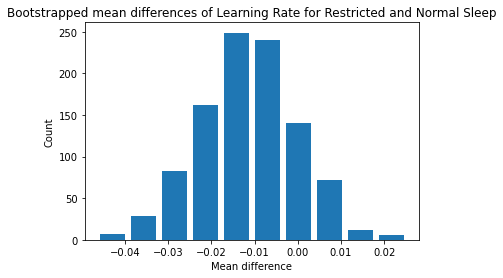

In [51]:
meandiff = np.zeros(1000)
for i in range(1000):
    var1 = np.random.choice(fLearning_rate_R_sleep, 60)
    var2 = np.random.choice(fLearning_rate_N_sleep, 60)
    meandiff[i] = np.mean(var1) - np.mean(var2)

plt.hist(meandiff, rwidth=0.8)
plt.xlabel('Mean difference')
plt.ylabel('Count')
plt.title('Bootstrapped mean differences of Learning Rate for Restricted and Normal Sleep')

In [52]:
stats.wilcoxon(meandiff)

WilcoxonResult(statistic=35423.5, pvalue=2.8360278175698295e-122)

In [53]:
stats.wilcoxon(meandiff, alternative='less')

WilcoxonResult(statistic=35423.5, pvalue=1.4180139087849147e-122)

#### Increase in stress and sleepiness by sleep restriction

In [20]:
# Sleepiness
KSS_normalsleep = pstdf[pstdf['sleep'] == 'Normal sleep'][['KSS', 'subject']]
KSS_nosleep = pstdf[pstdf['sleep'] != 'Normal sleep'][['KSS','subject']]

In [21]:
KSS_normalsleep = KSS_normalsleep.groupby('subject').mean().sort_values(['subject']).to_numpy().ravel()

In [22]:
KSS_nosleep = KSS_nosleep.groupby('subject').mean().sort_values(['subject']).to_numpy().ravel()

In [26]:
stats.ttest_ind(KSS_normalsleep, KSS_nosleep)

Ttest_indResult(statistic=-9.59674137604122, pvalue=7.141560015668562e-14)

In [ ]:
stats.ttest_ind(KSS_normalsleep, KSS_nosleep)

In [27]:
#SUSS 
SUSS_normalsleep = pstdf[pstdf['sleep'] == 'Normal sleep'][['SUSS', 'subject']]
SUSS_nosleep = pstdf[pstdf['sleep'] != 'Normal sleep'][['SUSS','subject']]

In [28]:
SUSS_normalsleep = SUSS_normalsleep.groupby('subject').mean().sort_values(['subject']).to_numpy().ravel()

In [29]:
SUSS_nosleep = SUSS_nosleep.groupby('subject').mean().sort_values(['subject']).to_numpy().ravel()

In [30]:
stats.ttest_ind(SUSS_normalsleep, SUSS_nosleep)

Ttest_indResult(statistic=-1.7163192451849194, pvalue=0.09109659013437574)